# Topic modeling using gensim

In [1]:
# load all the data
import pandas as pd

path=r"../data/all-the-news"
article_set1=pd.read_csv(path+"/articles1.csv")
article_set2=pd.read_csv(path+"/articles2.csv")
article_set3=pd.read_csv(path+"/articles3.csv")

# load data
article_set=pd.concat([pd.concat([article_set1,article_set2]),article_set3]).reset_index()
article_set=article_set[['id', 'title', 'publication', 'author', 'date','year', 'month', 'url', 'content']]

In [175]:
# import all the important libraries
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from gensim.corpora import Dictionary
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models import LdaModel
from gensim.corpora import MmCorpus
from gensim.similarities import Similarity

from collections import OrderedDict
from datetime import datetime
import string
import numpy as np
import sys
import dill
import operator
import heapq

import logging
logging.basicConfig(filename='../data/gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.DEBUG)

### Preprocess articles

In [46]:
## treat each article as a single doc

def clean_article(article, tokenizer, stop, punct):
        
    article = article.lower()  # Convert to lowercase.
    
    article = tokenizer.tokenize(article)  # Split into words.
    
    # Remove numbers, but not words that contain numbers.
    article = [token for token in article if not token.isdigit()]
    
    # Remove words that are only one character.
    article = [token for token in article if len(token) > 3]
    
    # Remove stop-words
    article = [token for token in article if token not in stop]
    
    # Remove punctuation
    article = [token for token in article if token not in punct]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    article = [lemmatizer.lemmatize(token) for token in article]
    
    return article

def preprocess_article(article_list, tokenizer, stop, punct):
    
    articles=[]
    
    for article in article_list:
        
        articles.append(clean_article(article, tokenizer, stop, punct))
        
    return articles

In [20]:
## treat each sentence as a single doc

def clean_text(article, tokenizer, stop, punct):
    
    article = article.lower()  # Convert to lowercase.
    
    sentences = article.split('.') # Convert to lowercase.
    
    token_sentences = [tokenizer.tokenize(sentence.strip()) for sentence in sentences]  # Split into words.
    
    # Remove numbers, but not words that contain numbers.
    token_sentences = [[token for token in token_sentence if not token.isdigit()] for token_sentence in token_sentences]
    
    # Remove words that are only one character.
    token_sentences= [[token for token in token_sentence if len(token) > 3] for token_sentence in token_sentences]
    
    # Remove stop-words
    token_sentences = [[token for token in token_sentence if token not in stop] for token_sentence in token_sentences]
    
    # Remove punctuation
    token_sentences = [[token for token in token_sentence if token not in punct] for token_sentence in token_sentences]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    token_sentences = [[lemmatizer.lemmatize(token) for token in token_sentence] for token_sentence in token_sentences]
    
    return token_sentences

def preprocess(article_list, tokenizer, stop, punct):
    
    articles=[]
    
    for article in article_list:
        
        articles+=clean_text(article, tokenizer, stop, punct)
        
    return articles

### Train LDA models on a random sample of whole articleset

In [96]:
tokenizer = RegexpTokenizer(r'\w+')
    
# create English stop words list
en_stop = stopwords.words('english')
# custom stop words
cus_stop=['mr','mrs','ms','said','dr','percent','family','report','million','city','home','change','story','asked','mean','statement',
          'three','found','used','look','saying','long','news','question','among','came','little','without','already','least','though',
          'today','kind','give','month','often','whether','find','always','added','le','however','took','idea','believe','best','become',
          'others','person','keep','actually','talk','wrote','went','making','thought','last','done']

# finalize stop words
stop=en_stop+cus_stop
    
# punctuation characters
punct=set(string.punctuation) 

%time articles=preprocess_article(article_set['content'], tokenizer, stop, punct)

CPU times: user 6min 42s, sys: 25.5 s, total: 7min 7s
Wall time: 7min 25s


In [97]:
# Form_Trigrams (only ones that appear 20 times or more).
bigram = Phrases(articles, min_count=20)
bigram_mod = Phraser(bigram)
trigram = Phrases(bigram_mod[articles],min_count=10)
trigram_mod = Phraser(trigram)
articles = [trigram_mod[bigram_mod[article]] for article in articles]

#print (articles[0])

In [98]:
dictionary = Dictionary(articles)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.2, keep_n=200000)
print('Number of unique words after removing rare and common words:', len(dictionary))

# vectorize words into bag of words representation
corpus = [dictionary.doc2bow(article) for article in articles]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique words in initital documents: 391986
Number of unique words after removing rare and common words: 181761
Number of unique tokens: 181761
Number of documents: 142570


### Manually find the stop words

In [101]:
from collections import defaultdict
word_total=defaultdict(int)
for vector in corpus:
    if len(vector)>0:
        for word,frequency in vector:
            word_total[dictionary[word]]+=frequency
    else:
        pass
list_words=list(word_total.items())
list_words.sort(key=lambda item: item[1], reverse=True)
#[word for word,frequency in list_words[:100]]

In [100]:
# #Set training parameters and train the LDA model

# for num in range(50,60,2):
    
#     print ('testing topic number: %f...'%num)
    
#     params={
#         'num_topics':num,
#         'chunksize':2000,            # size of the doc looked at every pass
#         'passes':1,                  # number of passes through documents
#         'iterations':400,
#         'eval_every':1,
#     }
    
#     %time model = LdaModel(corpus, id2word=dictionary, **params)

num_of_topics= 50 #fill in a number
params={
        'num_topics':num_of_topics,
        'chunksize':2000,            # size of the doc looked at every pass
        'passes':2,                  # number of passes through documents
        'iterations':400,
        'eval_every':1,
    }

%time model = LdaModel(corpus, id2word=dictionary, **params)

CPU times: user 57min 9s, sys: 6min 11s, total: 1h 3min 21s
Wall time: 18min 17s


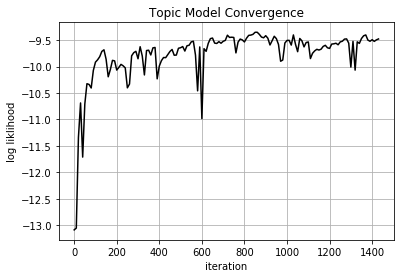

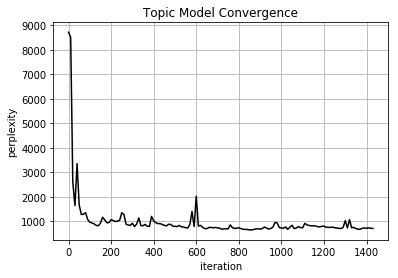

In [103]:
%matplotlib inline  
import re
import matplotlib.pyplot as plt
p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('../data/gensim.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iteration = list(range(0,len(tuples)*10,10))

plt.plot(iteration,liklihood,c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()

plt.plot(iteration,perplexity,c="black")
plt.ylabel("perplexity")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()

### Visualization with pyLDAvis

In [104]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

In [105]:
pyLDAvis.gensim.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
36     0.198404 -0.146729       1        1  6.992155
46     0.190349 -0.018588       2        1  6.018769
39     0.017821 -0.136770       3        1  5.750359
20     0.135170 -0.003340       4        1  4.958812
2      0.159557  0.019415       5        1  4.299224
18     0.125273  0.154781       6        1  3.719134
45     0.212480 -0.114803       7        1  3.513535
38     0.150682  0.164341       8        1  3.422882
35     0.157975 -0.013902       9        1  3.248224
32     0.058315 -0.221927      10        1  3.003612
27     0.020195  0.141790      11        1  2.614343
19     0.106498  0.006658      12        1  2.521562
34     0.108174  0.149624      13        1  2.471220
30     0.181015 -0.102916      14        1  2.332037
37    -0.052662 -0.014944      15        1  2.299153
44     0.085210  0.027868      16        1  2.277264
29     0.005691  0.131120      17        1  2.204879
8      0.022067  0.150646      18        1  2.028877
10    -0.046031  0.120948      19        1  2.005021
31     0.038181 -0.185346      20        1  1.919725
0      0.132990  0.073867      21        1  1.893587
7      0.036691 -0.096119      22        1  1.791064
21    -0.046858  0.082647      23        1  1.651484
49    -0.165842  0.072439      24        1  1.629476
28    -0.085167  0.073348      25        1  1.427097
11     0.067856  0.074262      26        1  1.408139
22    -0.014535 -0.114986      27        1  1.358222
16     0.105432  0.061046      28        1  1.336191
48    -0.173379 -0.018975      29        1  1.289083
24    -0.045116  0.021372      30        1  1.276868
23    -0.047287 -0.071465      31        1  1.274996
3     -0.088215  0.032614      32        1  1.227176
15    -0.016740  0.039793      33        1  1.205276
12    -0.008655 -0.149214      34        1  1.162136
26    -0.053954  0.075007      35        1  1.078983
41    -0.009444 -0.005917      36        1  1.073287
25    -0.154984 -0.031944      37        1  0.995371
43     0.024353 -0.038422      38        1  0.981274
1     -0.019445  0.133734      39        1  0.952659
17    -0.069382 -0.159521      40        1  0.930974
47    -0.147666  0.056639      41        1  0.906992
4     -0.201966  0.033495      42        1  0.864109
14    -0.085464  0.104693      43        1  0.780456
40    -0.093335 -0.041425      44        1  0.733652
42    -0.091366  0.089476      45        1  0.646328
13    -0.109303 -0.135966      46        1  0.575076
5     -0.114444  0.059800      47        1  0.552356
6     -0.128786 -0.172502      48        1  0.527344
9     -0.141185 -0.073677      49        1  0.472125
33    -0.129172 -0.082026      50        1  0.397443, topic_info=       Category           Freq                 Term          Total  loglift  \
term                                                                          
1200    Default  103682.000000                woman  103682.000000  30.0000   
1313    Default   69346.000000              company   69346.000000  29.0000   
1809    Default   74702.000000              clinton   74702.000000  28.0000   
187     Default   72950.000000           republican   72950.000000  27.0000   
867     Default   44652.000000               police   44652.000000  26.0000   
315     Default   29479.000000                black   29479.000000  25.0000   
291     Default   41026.000000               attack   41026.000000  24.0000   
2481    Default   27197.000000                china   27197.000000  23.0000   
6192    Default   22937.000000               muslim   22937.000000  22.0000   
3713    Default   43086.000000             democrat   43086.000000  21.0000   
385     Default   52332.000000                child   52332.000000  20.0000   
990     Default   34182.000000               school   34182.000000  19.0000   
5945    Default   32136.000000               russia   32136.000000  18.0000   
1189    Default 

In [163]:
#pyLDAvis.prepared_data_to_html(pyLDAvis.gensim.prepare(model, corpus, dictionary),template_type='general')

### Save / Load the model for future use

In [173]:
model.save('../data/lda_entireset.model')
dictionary.save_as_text('../data/dictionary')
MmCorpus.serialize('../data/corpus.mm', corpus)

In [166]:
model = LdaModel.load('../data/lda_entireset.model')
dictionary = Dictionary.load_from_text('../data/dictionary')
corpus=MmCorpus('../data/corpus.mm')

### Find the list of words in each topic

In [109]:
def explore_topic(lda_model, topic_number, top_nwords, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=top_nwords):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 5)))
    print('\n')

In [110]:
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_of_topics):
    print('Topic '+str(i)+' |---------------------\n')
    explore_topic(model,topic_number=i, top_nwords=20, output=True )

term                 frequency

Topic 0 |---------------------

plan                 0.027
bill                 0.024
program              0.015
cost                 0.011
obamacare            0.011
health_care          0.010
budget               0.009
republican           0.008
proposal             0.007
coverage             0.007
health               0.007
policy               0.006
insurance            0.006
system               0.005
funding              0.005
benefit              0.005
price                0.005
insurer              0.005
affordable_care      0.005
spending             0.005


Topic 1 |---------------------

china                0.071
chinese              0.025
tillerson            0.015
beijing              0.014
company              0.013
uber                 0.011
taiwan               0.010
boeing               0.006
drone                0.005
told_reuters         0.005
merger               0.004
hong_kong            0.004
technology           0.004
philippine 

policy               0.010
united_state         0.010
order                0.010
immigration          0.007
immigrant            0.007
rule                 0.005
administration       0.005
law                  0.005
citizen              0.005
federal              0.004
obama_administration 0.004
legal                0.004
executive_order      0.004
action               0.004
travel               0.003
trump_administration 0.003
nation               0.003
refugee              0.003
mexico               0.003
individual           0.003


Topic 19 |---------------------

company              0.014
apple                0.011
technology           0.011
data                 0.010
facebook             0.009
user                 0.008
system               0.008
online               0.007
internet             0.007
service              0.007
device               0.006
information          0.006
google               0.006
using                0.006
phone                0.005
computer            

book                 0.005
different            0.004
read                 0.004
seems                0.003
probably             0.003
course               0.003
real                 0.003
turn                 0.003
sort                 0.003
enough               0.003
maybe                0.003
word                 0.003
perhaps              0.003
piece                0.003
rather               0.002
le                   0.002
seem                 0.002
fact                 0.002
hard                 0.002
moment               0.002


Topic 37 |---------------------

event                0.015
protest              0.013
march                0.012
rally                0.008
protester            0.008
crowd                0.008
saturday             0.007
activist             0.006
member               0.006
supporter            0.005
movement             0.005
friday               0.004
jewish               0.004
street               0.004
washington           0.004
sign                

In [136]:
top_labels = {0 : 'Health Care',
              1 : 'Foreign Policy/China',
              2 : 'Economy',
              3 : 'Finance',
              4 : 'Demostic Affairs',
              5 : 'Disease',
              6 : 'Fitness/Lifestyle',
              7 : 'Sports',
              8 : 'Foreign Policy',
              9 : 'Religion',
              10: 'Foreign Policy',
              11: 'European Affairs',
              12: 'Sports',
              13: 'Politics/Election',
              14: 'Foreign Policy/Korea',
              15: 'Media',
              16: 'Court/Legal System',
              17: 'Food/Lifestyle',
              18: 'Immigration',
              19: 'Technology', 
              20: 'Politics/Election',
              21: 'Bussiness',
              22: 'Social Media',
              23: 'Domestic Affairs',
              24: 'Environment',
              25: 'Domestic Affairs',
              26: 'Government',
              27: 'Russia Investigation',
              28: 'Crime',
              29: 'Court/Legal System',
              30: 'Religion',
              31: 'Entertainment',
              32: 'Gender Issues',
              33: 'Unlabeled', #*
              34: 'Politics',
              35: 'Education',
              36: 'Unlabeled', #*
              37: 'Politics',
              38: 'Foreign Policy/Trade',
              39: 'Unlabeled', #*
              40: 'Entertainment',
              41: 'Race',
              42: 'Transportation/Travel',
              43: 'Money',
              44: 'Scientific Research',
              45: 'Politics',
              46: 'Politics',
              47: 'Auto Industry',
              48: 'Crime',
              49: 'Terrorism',
             }


### Figure out most relavant topic to each article

In [156]:
def get_doc_topic_dist(model, corpus,top_labels):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    topic_dist=[]
    final = []
    for index, d in enumerate(corpus):
        topic = []
        topic_candidate=[]
        top_3 = []
        
        #print ('processing article %f...'%index)
        for item in model[d]:
            heapq.heappush(topic,(-item[1],item[0]))
        for i in range(3):
            try:
                curr_top = heapq.heappop(topic)
            except:
                #print ('article %f cannot find topic %f'%(index,i+1))
                top_3.append(np.nan)
                topic_candidate.append(np.nan)
                continue
            top_3.append(top_labels[curr_top[1]]+'*'+str(-curr_top[0]))
            topic_candidate.append(top_labels[curr_top[1]])
            
        curr_top=False   
        for item in topic_candidate:
            if (item != "Unlabeled") and (item != np.nan):
                curr_top = item
                break
        if not curr_top:
            final.append(np.nan)
        else:
            final.append(curr_top)
                         
        topic_dist.append(top_3)
                         
    return final,topic_dist


In [157]:
#all_articles=preprocess_article(article_set['content'], tokenizer, stop, punct)
#all_corpus = [dictionary.doc2bow(article) for article in all_articles]
topic,topic_withscore=get_doc_topic_dist(model, corpus, top_labels)

In [ ]:
#len(topic)
assert len(article_set)==len(topic)

In [159]:
article_set[['topic1','topic2','topic3']]=pd.DataFrame(topic_withscore)
article_set['topic']=topic

In [160]:
article_set.head()

,id,title,publication,author,date,year,month,url,content,topic1,topic2,topic3,topic
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,Politics*0.45669132,Health Care*0.22221036,Court/Legal System*0.08490019,Politics
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",Crime*0.30302584,Unlabeled*0.28304937,Crime*0.09784402,Crime
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",Unlabeled*0.19544908,Unlabeled*0.14889707,Religion*0.097971134,Religion
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",Unlabeled*0.2989482,Religion*0.1702237,Gender Issues*0.11686472,Religion
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",Foreign Policy/Korea*0.61946124,Politics*0.19456775,Foreign Policy/Trade*0.09577953,Foreign Policy/Korea


### Save / Load file for future use

In [161]:
dill.dump(article_set, open('../data/article_set', 'wb'))

In [157]:
all_news= dill.load(open('../data/article_set', 'rb'))